In [1]:
import numpy as np
import pandas as pd
import csv

df = pd.read_csv('labeled_sample_600.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [2]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,tweetcreatedts,text,value
0,0.0,620503.0,2022-03-16 22:16:46,By sending weapons to Ukraine and cheer-leadin...,0
1,1.0,621695.0,2022-03-16 22:50:54,Here is the other NFT charity drop I'm a part ...,2
2,2.0,615671.0,2022-03-16 19:58:05,The Russian Orthodox Church is alienating Ukra...,0
3,3.0,622314.0,2022-03-16 23:06:47,@MSNBC Ã° War in #Ukraine is a Massive Bonanza...,0
4,4.0,623954.0,2022-03-16 23:51:20,"""We believe in peaceful and non-violent civil ...",2
5,5.0,589927.0,2022-03-16 09:07:52,Following talks with his #Iranian counterpart ...,0
6,6.0,613350.0,2022-03-16 18:50:42,"In this week's @TheNewArabVoice, we speak with...",0
7,7.0,596025.0,2022-03-16 12:05:59,It will take time for talks with #Russia to en...,1
8,8.0,612921.0,2022-03-16 18:35:09,If #Ukraine had student loan debts they'd neve...,0
9,9.0,591123.0,2022-03-16 09:46:36,Ã¢The #Polish government has suggested organis...,1


In [3]:
#Start to clean the data
import re
from bs4 import BeautifulSoup
from html import unescape

def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        message: a list of words containing the processed message. 

    '''
    message = message.lower()
    #remove urls
    message = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', message)
    #unescape characters
    soup = BeautifulSoup(unescape(message), 'lxml')
    message = soup.text
    #remove emoticons
    regrex_pattern = re.compile(pattern = "["   
        #graphs, symbols                        
        u"\U0001F300-\U0001F5FF" 
        #emoticons
        u"\U0001F600-\U0001F64F"
        #flags
        u"\U0001F1E0-\U0001F1FF" 
        #map and transport
        u"\U0001F680-\U0001F6FF"  
                           "]+", flags = re.UNICODE)
    message = regrex_pattern.sub(r'', message)
    #remove redundant white spaces
    message = re.sub(' +', ' ', message)
    #remove special characters 
    message = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', message)
     
    return message


In [4]:
df['text'] = df['text'].apply(clean_message)

In [5]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,tweetcreatedts,text,value
0,0.0,620503.0,2022-03-16 22:16:46,by sending weapons to ukraine and cheer leadin...,0
1,1.0,621695.0,2022-03-16 22:50:54,here is the other nft charity drop i m a part ...,2
2,2.0,615671.0,2022-03-16 19:58:05,the russian orthodox church is alienating ukra...,0
3,3.0,622314.0,2022-03-16 23:06:47,msnbc war in ukraine is a massive bonanza for...,0
4,4.0,623954.0,2022-03-16 23:51:20,we believe in peaceful and non violent civil ...,2
5,5.0,589927.0,2022-03-16 09:07:52,following talks with his iranian counterpart i...,0
6,6.0,613350.0,2022-03-16 18:50:42,"in this week s thenewarabvoice, we speak with ...",0
7,7.0,596025.0,2022-03-16 12:05:59,it will take time for talks with russia to end...,1
8,8.0,612921.0,2022-03-16 18:35:09,if ukraine had student loan debts they d never...,0
9,9.0,591123.0,2022-03-16 09:46:36,the polish government has suggested organisin...,1


In [6]:
!pip install flair

In [7]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

2022-04-23 17:25:20,109 loading file /Users/yannanzheng/.flair/models/sentiment-en-mix-distillbert_4.pt


In [8]:
#let's see how flair model work
sentence_try = Sentence("it will take time for talks with russia to end the war.")
print(sentence_try)
classifier.predict(sentence_try)
sentiment = sentence_try.labels[0]
sentiment_score = sentiment.score
result = {'result': sentiment.value, 'score':"%.2f" % sentiment_score}
print(result)

Sentence: "it will take time for talks with russia to end the war ."   [− Tokens: 13]
{'result': 'NEGATIVE', 'score': '0.96'}


In [9]:
#A helper function that predict the sentiment status and sentiment score, 
#prepare to store them into a csv(the next step)

def flair_prediction(x):

    sentence = Sentence(x)
    
    try:        
        classifier.predict(sentence)
        score = sentence.labels[0]
        staging_score = str(score).replace("(",",").replace(")","")
        
        sentiment_score = staging_score.split(",")
        
        if "POSITIVE" in str(sentiment_score[0]):
            return sentiment_score[0].strip(), float(sentiment_score[1].strip())
        elif "NEGATIVE" in str(sentiment_score[0]):
            return sentiment_score[0].strip(), float(sentiment_score[1].strip())
        
    except Exception:
        print(sentence)
        pass 
    
    return "ERROR",0.00

In [10]:
# create two columns for sentiment status and sentiment score
df['Sentiment_status'] = ""
df['Sentiment_score'] = np.nan

In [11]:
#using swifter to suppress the results 
import swifter
df["Sentiment_status"],df["Sentiment_score"] =  zip(*df["text"].swifter.apply(flair_prediction))

Pandas Apply: 100%|███████████████████████████| 600/600 [01:03<00:00,  9.49it/s]


In [12]:
#store the result into a csv
data_tofile = df[['text', 'value', 'Sentiment_status', 'Sentiment_score']]
data_tofile.to_csv('600_flair_score.csv')

<AxesSubplot:ylabel='Unnamed: 0'>

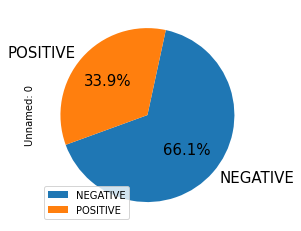

In [13]:
#generate a pie chart to see the ratio of sentiment status

import matplotlib.pyplot as plt
df.groupby(['Sentiment_status']).sum().plot(kind='pie', y='Unnamed: 0', autopct='%1.1f%%', startangle=200, fontsize=15)

In [14]:
df.groupby(["Sentiment_status"]).agg({'Sentiment_score': ['count','mean']})

Sentiment_score          
                           count      mean
Sentiment_status                          
NEGATIVE                     404  0.926424
POSITIVE                     196  0.878885

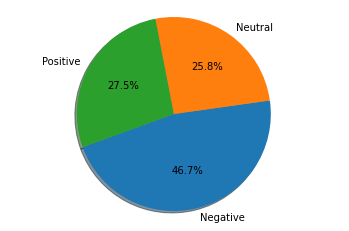

In [15]:
#our team labeled negative tweets as 0, neutral tweet as 1 and positive tweet as 2 in the value column.
negative = df[df["value"] == 0]
neutral = df[df["value"] == 1]
positive = df[df["value"] == 2]
percent_negative = len(negative)/600
percent_neutral = len(neutral)/600
percent_positive = len(positive)/600

#let's see a pie chart of hand_labeled status 
labels = 'Negative', 'Neutral', 'Positive'
sizes = percent_negative, percent_neutral, percent_positive
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=200)
ax1.axis('equal')
plt.show()

In [16]:
#count the number of tweets bese on their flair score
def cut_off_score(x):
    count = 0
    for i in df.index:
        num = df['Sentiment_score'][i]
        if num <= x:
             count += 1 
    return count

In [17]:
num_90 = cut_off_score(0.9)
print(num_90)
num_96 = cut_off_score(0.96)
print(num_96)
num_98 = cut_off_score(0.98)
print(num_98)

167
228
277


In [18]:
#if the tweet's score less than the target number, replace the sentiment status to Neutral.
def replace_score(x):
    score_x = df
    score_x.loc[score_x['Sentiment_score'] <= x, "Sentiment_status"] = "Neutral"  
    return score_x

In [19]:
#compare each tweet's sentiment status to hand-labeled value, get the number of tweets that have same value 
#on sentiment status and hand-labeled value.
def accuracy(replaced_set):
    count = 0
    for i in replaced_set.index:
        if (replaced_set['Sentiment_status'][i] == "NEGATIVE" and replaced_set['value'][i]  == 0):
            count += 1
        elif (replaced_set['Sentiment_status'][i] == "Neutral" and replaced_set['value'][i]  == 1):
            count += 1
        elif (replaced_set['Sentiment_status'][i] == "POSITIVE" and replaced_set['value'][i]  == 2):
            count += 1
    return count

The total number of tweets which sentiment status equals hand-labeled value: 346
Accuracy: 0.5767


Sentiment_score          
                           count      mean
Sentiment_status                          
NEGATIVE                     308  0.987220
Neutral                      167  0.719986
POSITIVE                     125  0.977879

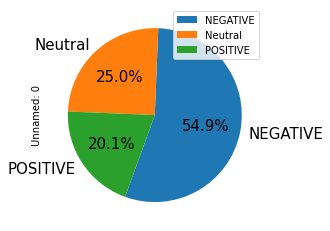

In [21]:
a = replace_score(0.9)
count_90 = accuracy(a)
rate = count_90 / 600
print("The total number of tweets which sentiment status equals hand-labeled value:" , count_90)
print("Accuracy:" , round(rate, 4))
df.groupby(['Sentiment_status']).sum().plot(kind='pie', y='Unnamed: 0', autopct='%1.1f%%', startangle=250, fontsize=15)
df.groupby(["Sentiment_status"]).agg({'Sentiment_score': ['count','mean']})

The total number of tweets which sentiment status equals hand-labeled value:  329
Accuracy: 0.5483


Sentiment_score          
                           count      mean
Sentiment_status                          
NEGATIVE                     272  0.994078
Neutral                      228  0.777577
POSITIVE                     100  0.988598

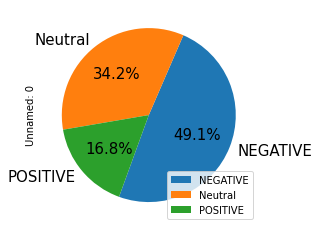

In [22]:
b = replace_score(0.96)
count_96 = accuracy(b)
rate = count_96 / 600
print("The total number of tweets which sentiment status equals hand-labeled value: " , count_96)
print("Accuracy:" , round(rate, 4))
df.groupby(['Sentiment_status']).sum().plot(kind='pie', y='Unnamed: 0', autopct='%1.1f%%', startangle=250, fontsize=15)
df.groupby(["Sentiment_status"]).agg({'Sentiment_score': ['count','mean']})

The total number of tweets which sentiment status equals hand-labeled value:  310
Accuracy: 0.5167


Sentiment_score          
                           count      mean
Sentiment_status                          
NEGATIVE                     247  0.996396
Neutral                      277  0.811833
POSITIVE                      76  0.994064

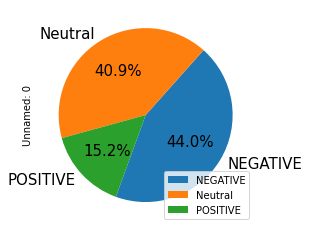

In [23]:
c = replace_score(0.98)
count_98 = accuracy(c)
rate = count_98 / 600
print("The total number of tweets which sentiment status equals hand-labeled value: " , count_98)
print("Accuracy:" , round(rate, 4))
df.groupby(['Sentiment_status']).sum().plot(kind='pie', y='Unnamed: 0', autopct='%1.1f%%', startangle=250, fontsize=15)
df.groupby(["Sentiment_status"]).agg({'Sentiment_score': ['count','mean']})